# Jupiter's Notebook for Scenario 03
Requieres: [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/), [imbalanced-learn](https://imbalanced-learn.org/stable/)<br>
`pip install category_encoders`<br>
`pip install imbalanced-learn`

In [1]:
#import libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [2]:
#To identify class 0 and 1, respectively
target_names = ['class 0', 'class 1']

In [3]:
#load dataset
df=pd.read_csv('esc-03-Mixed-traffic.csv')

In [4]:
#check dimensions
df.shape

(425649, 52)

## Pre-feature selection

In [5]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

proto                 0
ts                    0
srcIP                 0
srcPrt                0
dstIP                 0
dstPrt                0
flowduration          0
total_fpackets        0
total_bpackets        0
total_fpktl           0
total_bpktl           0
min_fpktl             0
min_bpktl             0
max_fpktl             0
max_bpktl             0
mean_fpktl            0
mean_bpktl            0
std_fpktl             0
std_bpktl             0
total_fipt            0
total_bipt            0
min_fipt              0
min_bipt              0
max_fipt              0
max_bipt              0
mean_fipt             0
mean_bipt             0
std_fipt              0
std_bipt              0
fpsh_cnt              0
bpsh_cnt              0
furg_cnt              0
burg_cnt              0
total_fhlen           0
total_bhlen           0
fPktsPerSecond        0
bPktsPerSecond        0
flowPktsPerSecond     0
flowBytesPerSecond    0
mean_flowpktl         0
std_flowpktl          0
mean_flowipt    

In [6]:
#Dropping Rows with NA inplace
df.dropna(inplace=True)

In [7]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    425649
srcIP                  14548
srcPrt                 58384
dstIP                  14533
dstPrt                   210
flowduration          243270
total_fpackets           734
total_bpackets           909
total_fpktl             8911
total_bpktl            19117
min_fpktl                133
min_bpktl                495
max_fpktl               1207
max_bpktl                901
mean_fpktl             17918
mean_bpktl             22846
std_fpktl              31081
std_bpktl              29105
total_fipt             99977
total_bipt             80181
min_fipt               57495
min_bipt               32892
max_fipt               97386
max_bipt               74151
mean_fipt              96833
mean_bipt              78646
std_fipt               75211
std_bipt               65535
fpsh_cnt                 137
bpsh_cnt                 413
furg_cnt                   1
burg_cnt                   1
total_fhlen             3302
total_bhlen   

In [8]:
#delete columns with a single unique value
#get the indexes of the single-valued columns
counts=df.nunique()
to_del=[i for i,v in enumerate(counts) if v==1]
print(to_del)
#drop unless columns
df.drop(df.columns[to_del],axis=1,inplace=True)
print(df.shape)

[31, 32, 47]
(425649, 49)


In [9]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    425649
srcIP                  14548
srcPrt                 58384
dstIP                  14533
dstPrt                   210
flowduration          243270
total_fpackets           734
total_bpackets           909
total_fpktl             8911
total_bpktl            19117
min_fpktl                133
min_bpktl                495
max_fpktl               1207
max_bpktl                901
mean_fpktl             17918
mean_bpktl             22846
std_fpktl              31081
std_bpktl              29105
total_fipt             99977
total_bipt             80181
min_fipt               57495
min_bipt               32892
max_fipt               97386
max_bipt               74151
mean_fipt              96833
mean_bipt              78646
std_fipt               75211
std_bipt               65535
fpsh_cnt                 137
bpsh_cnt                 413
total_fhlen             3302
total_bhlen             4475
fPktsPerSecond        224935
bPktsPerSecond

In [10]:
#delete ts, srcIP and dstIP features
df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

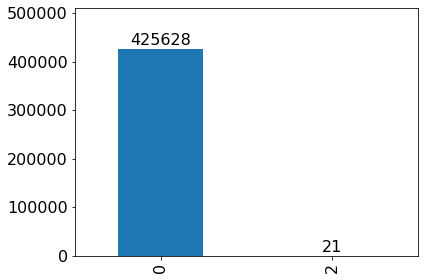

In [11]:
#Consider columns that have very few values, e.g. flow_cwr column
ax = df['flow_ece'].value_counts().plot(kind='bar',fontsize=16) 
for p in ax.patches:
    x = p.get_x()
    h = p.get_height()
    w = p.get_width()
    ax.annotate(f'{h:.0f}\n', (x + w/2, h), ha='center', va='center', size=16)
plt.margins(y=0.2)
plt.tight_layout()
plt.show()

In [12]:
#delete flow_ece column
df.drop('flow_ece',axis=1,inplace=True)

In [13]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 422898, 1: 2751})

In [14]:
#Delete Rows That Contain Duplicate Data
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(425649, 45)
(422778, 45)


In [15]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 420074, 1: 2704})

In [16]:
df

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,...,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_cwr,downUpRatio,label
0,TCP,37243,25,1.018562,3,3,186,162,62,54,...,4.381781,0.203716,0.283249,0,3,3,3,0,0.870968,0
1,TCP,63152,80,0.477808,11,16,1106,15237,60,54,...,656.407898,0.018434,0.037705,2,2,0,26,0,13.776672,0
2,TCP,52841,80,0.309601,6,7,629,6065,60,54,...,642.639771,0.027473,0.042772,0,2,1,12,0,9.642289,0
3,TCP,80,26739,60.019398,2,0,2868,0,1434,0,...,0.000000,60.019398,0.000000,0,0,0,2,0,0.000000,0
4,TCP,38554,80,17.941672,48,87,4594,116619,60,54,...,655.934814,0.227301,1.555660,1,2,1,134,0,25.385067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425644,UDP,47379,53,0.000000,1,0,71,0,71,0,...,0.000000,0.000000,0.000000,0,0,0,0,0,0.000000,0
425645,UDP,65320,53,0.000345,1,1,83,175,83,175,...,65.053825,0.000345,0.000000,0,0,0,0,0,2.108434,0
425646,UDP,31073,53,0.000231,1,1,85,177,85,177,...,65.053825,0.000231,0.000000,0,0,0,0,0,2.082353,0
425647,UDP,6141,53,0.000173,1,1,85,144,85,144,...,41.719299,0.000173,0.000000,0,0,0,0,0,1.694118,0


In [17]:
#check % class distribution 
y=df['label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 420074 of 422778 (99.4%)
> Class 1 : 2704 of 422778 (0.6%)


# Coding of categorical variables
[Target encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for categorical features will be used to encode three nominal categorical variables: protocol, source and destination ports. This method is supervised and requires training.

In [18]:
#Data types for each attibute
df.dtypes

proto                  object
srcPrt                  int64
dstPrt                  int64
flowduration          float64
total_fpackets          int64
total_bpackets          int64
total_fpktl             int64
total_bpktl             int64
min_fpktl               int64
min_bpktl               int64
max_fpktl               int64
max_bpktl               int64
mean_fpktl            float64
mean_bpktl            float64
std_fpktl             float64
std_bpktl             float64
total_fipt            float64
total_bipt            float64
min_fipt              float64
min_bipt              float64
max_fipt              float64
max_bipt              float64
mean_fipt             float64
mean_bipt             float64
std_fipt              float64
std_bipt              float64
fpsh_cnt                int64
bpsh_cnt                int64
total_fhlen             int64
total_bhlen             int64
fPktsPerSecond        float64
bPktsPerSecond        float64
flowPktsPerSecond     float64
flowBytesP

In [19]:
#create training and test dataset
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [20]:
#load library for target encoder 
from category_encoders import TargetEncoder

In [21]:
# Selecting the three categorical variables to be coded
enc = TargetEncoder(cols=['proto','srcPrt','dstPrt'])

# transform the datasets
training_numeric_dataset = enc.fit_transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)

In [22]:
#show the coded features
training_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,...,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_cwr,downUpRatio
406917,0.00021,1.069572e-07,0.000023,2.351661,1,1,74,303,74,303,...,188.5,161.927460,2.351661,0.000000,0,0,0,0,0,4.094594
338618,0.00021,0.000000e+00,0.000023,0.649577,1,1,82,227,82,227,...,154.5,102.530487,0.649577,0.000000,0,0,0,0,0,2.768293
240805,0.00021,1.151851e-04,0.000023,0.002353,2,2,169,301,79,149,...,117.5,38.388367,0.000840,0.001122,0,0,0,0,0,1.781065
182074,0.00021,4.286154e-05,0.000023,0.000111,1,1,161,54,161,54,...,107.5,75.660423,0.000111,0.000000,0,0,0,0,0,0.335404
314247,0.00021,3.037190e-04,0.000023,1.976254,2,2,176,934,88,467,...,277.5,218.815750,0.945076,0.990426,0,0,0,0,0,5.306818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260878,0.00021,7.902285e-07,0.000023,0.000472,1,1,72,347,72,347,...,209.5,194.454361,0.000472,0.000000,0,0,0,0,0,4.819445
368261,0.00021,7.633848e-04,0.000023,0.000242,1,1,81,149,81,149,...,115.0,48.083260,0.000242,0.000000,0,0,0,0,0,1.839506
132675,0.00021,2.147608e-06,0.000023,0.000240,1,1,85,136,85,136,...,110.5,36.062447,0.000240,0.000000,0,0,0,0,0,1.600000
147732,0.00021,0.000000e+00,0.000023,61.150707,10,0,808,0,71,0,...,80.8,5.159673,6.794523,5.594150,0,0,0,0,0,0.000000


In [23]:
#show the coded features
testing_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,...,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_cwr,downUpRatio
225200,0.000210,2.907315e-07,0.000023,0.000227,1,1,80,131,80,131,...,105.500000,36.062447,0.000227,0.000000,0,0,0,0,0,1.637500
337858,0.000210,2.907315e-07,0.000023,0.000236,1,1,74,138,74,138,...,106.000000,45.254833,0.000236,0.000000,0,0,0,0,0,1.864865
404282,0.000210,1.151851e-04,0.000023,19.993312,1,1,74,74,74,74,...,74.000000,0.000000,19.993313,0.000000,0,0,0,0,0,1.000000
65570,0.000210,1.151851e-04,0.000023,0.000343,1,1,77,77,77,77,...,77.000000,0.000000,0.000343,0.000000,0,0,0,0,0,1.000000
69846,0.000210,0.000000e+00,0.000023,2.860653,12,12,1116,1116,93,93,...,93.000000,0.000000,0.154731,0.104448,0,0,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269777,0.000210,5.834443e-06,0.000023,0.711955,1,1,78,183,78,183,...,130.500000,74.246216,0.711955,0.000000,0,0,0,0,0,2.346154
15294,0.055365,3.037190e-04,0.045616,1.405245,4,3,506,602,60,54,...,158.285714,174.926376,0.249384,0.355009,0,2,1,6,0,1.189723
13885,0.055365,7.633848e-04,0.045616,4.520789,17,19,1772,21016,66,66,...,633.000000,658.590454,0.129182,0.262038,2,2,0,35,0,11.860045
318886,0.000210,1.447529e-08,0.000023,6.740578,1,1,69,142,69,142,...,105.500000,51.618793,6.740578,0.000000,0,0,0,0,0,2.057971


# Standardization and scaling of numerical variables

In [24]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [25]:
X_train_prep = preprocessor.fit_transform(training_numeric_dataset)
X_test_prep  = preprocessor.transform(testing_numeric_dataset)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

In [26]:
#Dimensions of training and testing datasets
X_train_prep.shape, X_test_prep.shape

((338222, 44), (84556, 44))

# Feature selection
Exclusion of variables with variance close to zero

In [27]:
#join the prepared traing and test datasets in a single array X and y
X = np.vstack((X_train_prep, X_test_prep))
y = np.hstack((y_train, y_test))

In [28]:
collections.Counter(y)

Counter({0: 420074, 1: 2704})

>Threshold=0.00, Features=44
>Threshold=0.05, Features=43
>Threshold=0.10, Features=42
>Threshold=0.15, Features=42
>Threshold=0.20, Features=42
>Threshold=0.25, Features=42
>Threshold=0.30, Features=42
>Threshold=0.35, Features=42
>Threshold=0.40, Features=41
>Threshold=0.45, Features=41
>Threshold=0.50, Features=41
>Threshold=0.55, Features=40
>Threshold=0.60, Features=40
>Threshold=0.65, Features=40


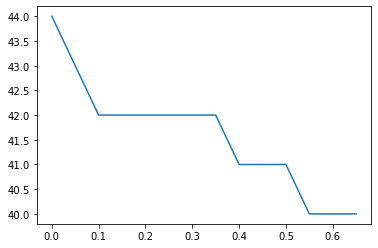

In [29]:
#the VarianceThreshold class from sklearn support a type of feature selection
from sklearn.feature_selection import VarianceThreshold
from numpy import arange
#split data into inputs
#data=df_float.values
#X=data[:,:]
#define thresholds to check
thresholds = arange(0.0,0.7,0.05)
#apply transform with each treshold
results=list()
for t in thresholds:
    #define the transform
    transform = VarianceThreshold(threshold=t)
    #transform the input data
    X_sel=transform.fit_transform(X)
    #determine the number of input features
    n_features=X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' %(t,n_features))
    #store the result
    results.append(n_features)
#plot the theshold vs the number of selected features
plt.plot(thresholds,results)
plt.show()

In [30]:
#new set of selected features
X=X_sel
print(X.shape)

(422778, 40)


# Create Machine Learning Models

### a) Grid search with Logistic Regression (GS-LR)

In [31]:
# grid search class weights with logistic regression for imbalanced classification

model = LogisticRegression(solver='lbfgs',max_iter=1000)
# define grid
balance = [{0:0.001,1:1.0},{0:0.01,1:1.0}, {0:0.1,1:1}, {0:1,1:100},{0:1,1:200}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv,
scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.997819 using {'class_weight': {0: 0.001, 1: 1.0}}
0.997819 (0.002107) with: {'class_weight': {0: 0.001, 1: 1.0}}
0.997288 (0.002282) with: {'class_weight': {0: 0.01, 1: 1.0}}
0.993947 (0.008997) with: {'class_weight': {0: 0.1, 1: 1}}
0.996945 (0.002577) with: {'class_weight': {0: 1, 1: 100}}
0.997557 (0.002307) with: {'class_weight': {0: 1, 1: 200}}


C:\Users\pvelarde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
## split into train test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
#Using the obtained weights for training the model GS-LR
weights = {0: 0.01, 1: 1.0}
model = LogisticRegression(solver='lbfgs', class_weight=weights,max_iter=2000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

C:\Users\pvelarde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROCAUC score: 0.9897449555250548
Accuracy score: 0.9955414163394674
F1 score: 0.744406779661017
Recall score: 0.9838709677419355
Precision score: 0.5986913849509269
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     83998
     class 1       0.60      0.98      0.74       558

    accuracy                           1.00     84556
   macro avg       0.80      0.99      0.87     84556
weighted avg       1.00      1.00      1.00     84556



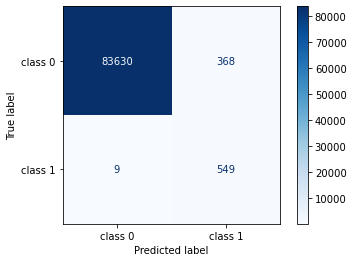

In [33]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))
print('Precision score:',precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
plot_confusion_matrix(model, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

 ### b) Logistic Regression with Synthetic minority over-sampleing technique (LR+SMOTE)

In [42]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit target and predictor variable
X_smote , y_smote = smote.fit_resample(X, y)

print('Origianl dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 420074, 1: 2704})
Resample dataset shape: Counter({0: 420074, 1: 420074})


In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smote, y_smote, test_size =0.20, random_state=42)

In [44]:
model2=LogisticRegression(solver='lbfgs',max_iter=2000)
model2.fit(X_train2, y_train2)
y_pred2=model2.predict(X_test2)

C:\Users\pvelarde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROCAUC score: 0.9943801251819663
Accuracy score: 0.9943819556031661
F1 score: 0.994398556916358
Recall score: 0.9952489547700494
Precision score: 0.9935496110794916
              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99     83838
     class 1       0.99      1.00      0.99     84192

    accuracy                           0.99    168030
   macro avg       0.99      0.99      0.99    168030
weighted avg       0.99      0.99      0.99    168030



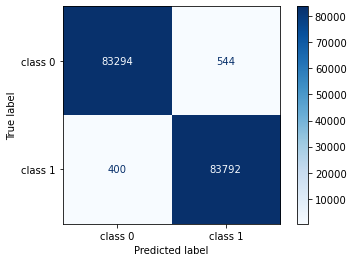

In [45]:
print('ROCAUC score:',roc_auc_score(y_test2, y_pred2))
print('Accuracy score:',accuracy_score(y_test2, y_pred2))
print('F1 score:',f1_score(y_test2, y_pred2))
print('Recall score:',recall_score(y_test2, y_pred2))
print('Precision score:',precision_score(y_test2, y_pred2))

print(classification_report(y_test2, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, X_test2, y_test2, display_labels=target_names,cmap=plt.cm.Blues); 

### c) Weighted Support Vector Machine (W-SVM)

In [47]:
#train a model using Penalized-SVM on the original imbalanced dataset:
# we can add class_weight='balanced' to add panalize mistake
model_SVM = SVC(class_weight='balanced', probability=True)
model_SVM.fit(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)

In [48]:
y_pred_SVM = model_SVM.predict(X_test)

ROCAUC score: 0.5984630458431294
Accuracy score: 0.207531103647287
F1 score: 0.01629525235620541
Recall score: 0.9946236559139785
Precision score: 0.008214920071047958
              precision    recall  f1-score   support

     class 0       1.00      0.20      0.34     83998
     class 1       0.01      0.99      0.02       558

    accuracy                           0.21     84556
   macro avg       0.50      0.60      0.18     84556
weighted avg       0.99      0.21      0.33     84556



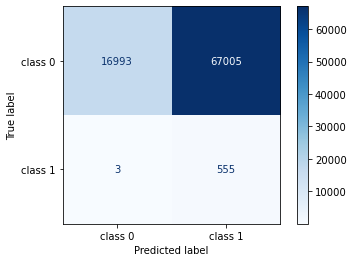

In [49]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred_SVM))
print('Accuracy score:',accuracy_score(y_test, y_pred_SVM))
print('F1 score:',f1_score(y_test, y_pred_SVM))
print('Recall score:',recall_score(y_test, y_pred_SVM))
print('Precision score:',precision_score(y_test, y_pred_SVM))

print(classification_report(y_test, y_pred_SVM, target_names=target_names))
plot_confusion_matrix(model_SVM, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

# Undersampling using CNN
Condensed Nearest Neighbor (CNN) is used to remove redundant examples from the interior of the density of the majority class. 

In [50]:
# undersample an imbalanced dataset with the Condensed Nearest Neighbor Rule
from imblearn.under_sampling import CondensedNearestNeighbour

In [51]:
counter = Counter(y)
print(counter)

Counter({0: 420074, 1: 2704})


In [52]:
# define the undersampling method
undersample = CondensedNearestNeighbour(n_neighbors=1)
# transform the dataset
Xu, yu = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(yu)
print(counter)

Counter({1: 2704, 0: 219})


### d) Weighted Decision Tree with Condensed Nearest Neighbor (DT+CNN)
The `DecisionTreeClassifier` class provides the class weight argument that can be speci ed as a model hyperparameter. The class weight is a dictionary that de nes each class label (e.g. 0 and 1) and the weighting to apply in the calculation of group purity for splits in the decision tree when tting the model.

In [53]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(Xu, yu, test_size =0.20, random_state=42)

In [54]:
# define model
model_DT = DecisionTreeClassifier(class_weight='balanced')
#model performance
model_DT.fit(X_train3, y_train3)
y_pred_DT=model_DT.predict(X_test3)

ROCAUC score: 0.9308939674004368
Accuracy score: 0.9880341880341881
F1 score: 0.9935602575896965
Recall score: 0.9981515711645101
Precision score: 0.989010989010989
              precision    recall  f1-score   support

     class 0       0.97      0.86      0.92        44
     class 1       0.99      1.00      0.99       541

    accuracy                           0.99       585
   macro avg       0.98      0.93      0.95       585
weighted avg       0.99      0.99      0.99       585



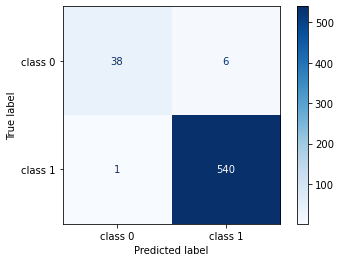

In [55]:
print('ROCAUC score:',roc_auc_score(y_test3, y_pred_DT))
print('Accuracy score:',accuracy_score(y_test3, y_pred_DT))
print('F1 score:',f1_score(y_test3, y_pred_DT))
print('Recall score:',recall_score(y_test3, y_pred_DT))
print('Precision score:',precision_score(y_test3, y_pred_DT))

print(classification_report(y_test3, y_pred_DT, target_names=target_names))
plot_confusion_matrix(model_DT, X_test3, y_test3, display_labels=target_names,cmap=plt.cm.Blues);

### e) Support Vector Machine with Condensed Nearest Neighbor (SVM+CNN)

In [58]:
model_SVM_cnn = SVC(class_weight='balanced', probability=True)
model_SVM_cnn.fit(X_train3, y_train3)
y_pred_SVM_cnn = model_SVM_cnn.predict(X_test3)

ROCAUC score: 0.8307427323138968
Accuracy score: 0.9572649572649573
F1 score: 0.9769585253456222
Recall score: 0.9796672828096118
Precision score: 0.9742647058823529
              precision    recall  f1-score   support

     class 0       0.73      0.68      0.71        44
     class 1       0.97      0.98      0.98       541

    accuracy                           0.96       585
   macro avg       0.85      0.83      0.84       585
weighted avg       0.96      0.96      0.96       585



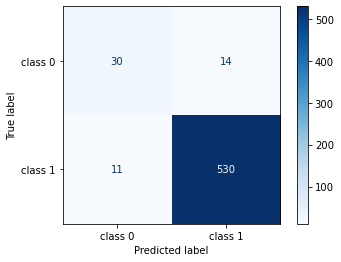

In [59]:
print('ROCAUC score:',roc_auc_score(y_test3, y_pred_SVM_cnn))
print('Accuracy score:',accuracy_score(y_test3, y_pred_SVM_cnn))
print('F1 score:',f1_score(y_test3, y_pred_SVM_cnn))
print('Recall score:',recall_score(y_test3, y_pred_SVM_cnn))
print('Precision score:',precision_score(y_test3, y_pred_SVM_cnn))

print(classification_report(y_test3, y_pred_SVM_cnn, target_names=target_names))
plot_confusion_matrix(model_SVM_cnn, X_test3, y_test3, display_labels=target_names,cmap=plt.cm.Blues);